# MS&E 234 Project

### Data cleaning

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from random import sample
import itertools
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import pickle

### Load data

In [2]:
df_raw = pd.DataFrame()
for i in range(1, 4+1):
    df_raw = pd.concat([df_raw, pd.read_csv(f'../netflix-prize-kaggle-data/combined_data_{i}.txt',
        header=None,
        names=['CustomerID', 'Rating', 'Date'])])
df_raw = df_raw.reset_index(drop = True)
df_raw

,CustomerID,Rating,Date
0,1:,NaN,NaN
1,1488844,3.0,2005-09-06
2,822109,5.0,2005-05-13
3,885013,4.0,2005-10-19
4,30878,4.0,2005-12-26
...,...,...,...
100498272,1790158,4.0,2005-11-01
100498273,1608708,3.0,2005-07-19
100498274,234275,1.0,2004-08-07
100498275,255278,4.0,2004-05-28


### Subset data as in paper (Calandrino 2011)

In [2]:
def buildDataset(df, userList, train):
    print("Entire dataset: 100498277 ratings; 480189 users")
    # Sample 10000 users
    df = df[df['CustomerID'].isin(userList)]
    print(f"Subset of 10000 users: {df.shape[0]} ratings; {df['CustomerID'].nunique()} users")

    if train:
        # Assume each user makes a random 50% of transactions public
        idxs = df[['CustomerID']].reset_index().groupby('CustomerID').agg({'index':lambda x: list(x)}).to_numpy().tolist()
        drop_idxs = []
        for i in range(len(idxs)):
            drop_idxs.append(sample(idxs[i][0], len(idxs[i][0]) // 2))
        drop_idxs = list(itertools.chain(*drop_idxs))
        df = df.drop(drop_idxs)
        print(f'After making 50% private: {df.shape[0]} ratings; {df.CustomerID.nunique()} users')

        # Only consider users with at least 100 public transactions
        df = df[df['CustomerID'].isin(df['CustomerID'].value_counts()[df['CustomerID'].value_counts() > 100].index)]
        print(f'Filter for users with >= 100 public transactions: {df.shape[0]} ratings; {df.CustomerID.nunique()} users')

    # Subset the data to analyze only ratings from July 2005
    df = df[df['Date'].apply(lambda x: type(x) == str and bool(re.match(r'2005-07.*', x)))]
    print(f'Only July 2005: {df.shape[0]} ratings; {df["CustomerID"].nunique()} users')
          
    return df

In [2]:
# extract movie ID's from raw data, combine these with df
# The data files follow the following format:
# Movie ID:
# CustomerID, Rating, Date
# ...

def addMovieInfo(df, movieDF):
    movieRows = np.array(movieDF.index)
    movieIDs = []
    currIdx = 0
    for row in df.itertuples(index = True, name = 'Pandas'):
        currRow = row.Index
        while currIdx < len(movieRows) - 1:
            nextMovieRow = movieRows[currIdx + 1]
            if currRow > nextMovieRow:
                currIdx += 1
            else:
                break
        movieIDs.append(currIdx)
    df["MovieID"] = movieIDs
    df['Day'] = pd.DatetimeIndex(df['Date']).day
    return df

In [3]:
# input: 2 sets x, y
# output: for binary vectors x and y: cosine similarity = |x and y| / sqrt(|x||y|)
def getCosSim(x, y):
    return len(x.intersection(y)) / np.sqrt(len(x) * len(y))

In [4]:
# input: sparse binary adjList
# output: dict of the 50 most similar items and scores, in format: dict[movieID] => ([(items, scores)])
def getSimListDaily(adjList):
    simList = {}
    for key1 in adjList.keys():
        cosSims = []
        for key2 in adjList.keys():
            if key1 == key2:
                continue
            cosSim = getCosSim(adjList[key1], adjList[key2])
            cosSims.append((key2, cosSim))
        simList[key1] = sorted(cosSims, key = lambda x: (-x[1], x[0]))[:50]
    return simList

In [5]:
# input: dataframe of customerIDs, Ratings, Day of Month, and MovieIDs
# input dataframe should contain both public and private data, as the recc system uses all available information
# output: list of 50 related movies and similarity ratings per day
# on each consecutive day, more data is used by the recc system
# uses cosine similarity on a binary matrix
def getSimListMonthly(df):
    # store binary matrix in sparse adjacency list format
    # adjList[movieID] => set of customerIDs
    adjList = defaultdict(set)
    
    simLists = []
    
    for day in tqdm(sorted(df["Day"].unique())):
        # add new movies from today to adjList
        currDF = df[df["Day"] == day]
        for row in currDF.itertuples(index = True, name = 'Pandas'):
            adjList[row.MovieID].add(row.CustomerID)
        
        # compute similarity scores
        currSimList = getSimListDaily(adjList)
        simLists.append(currSimList)
    return simLists

In [8]:
movieDF = df_raw[df_raw['Rating'].isnull()]
userList = sample(df_raw.dropna()['CustomerID'].unique().tolist(), 10000)
dfTrain = buildDataset(df_raw, userList, train = True)
dfTrain = addMovieInfo(dfTrain, movieDF)
dfTest = buildDataset(df_raw, userList, train = False)
dfTest = addMovieInfo(dfTest, movieDF)
dfTrain.to_csv("train/Trial1.csv")
dfTest.to_csv("test/Trial1.csv")

Entire dataset: 100498277 ratings; 480189 users
Subset of 10000 users: 2086064 ratings; 10000 users
After making 50% private: 1045448 ratings; 10000 users
Filter for users with >= 100 public transactions: 806422 ratings; 3159 users
Only July 2005: 35238 ratings; 1999 users
Entire dataset: 100498277 ratings; 480189 users
Subset of 10000 users: 2086064 ratings; 10000 users
Only July 2005: 100667 ratings; 4439 users


In [9]:
simLists = getSimListMonthly(dfTest)

In [10]:
fileName = 'simLists/Trial1.pkl'
with open(fileName, 'wb') as handle:
    pickle.dump(simLists, handle)

In [6]:
fileName = 'simLists/Trial1.pkl'
with open(fileName, 'rb') as handle:
    simLists = pickle.load(handle)

In [7]:
for i in tqdm(range(len(simLists))):
    for key in simLists[i].keys():
        simLists[i][key] = dict(simLists[i][key])

In [8]:
dfTrain = pd.read_csv("train/Trial1.csv", index_col = 0)
dfTest = pd.read_csv("test/Trial1.csv", index_col = 0)

In [9]:
countDF = dfTest.groupby(["CustomerID", "Day"]).count()
print(f"number of (user, date) pairs: {countDF.shape[0]} ")
countDF = countDF[countDF["Rating"] <= 5]
print(f"(user, date) pairs with <= 5 transactions: {countDF.shape[0]}")
validUsers = set(dfTrain["CustomerID"].unique())
countDF = countDF.reset_index()
countDF = countDF[countDF["CustomerID"].isin(validUsers)]
#monthlyCountDF = dfTest.groupby(["CustomerID"]).count()
print(f"filter by users with >= 100 transactions (in the whole dataset): {countDF.shape[0]}")
print("final transaction count: ", countDF["Rating"].sum())
#validUsers = set(monthlyCountDF[(monthlyCountDF["Rating"] > 100).values].index)
#countDF = countDF[countDF["CustomerID"].isin(validUsers)]
#print(f"filter by users with >= 100 transactions (July): {countDF.shape[0]}")
userPairs = countDF[["CustomerID", "Day"]].to_numpy()

# reset countDF to contain full count info
countDF = dfTest.groupby(["CustomerID", "Day"]).count()
countDF = countDF.reset_index()

number of (user, date) pairs: 14732 
(user, date) pairs with <= 5 transactions: 12233
filter by users with >= 100 transactions (in the whole dataset): 7121
final transaction count:  13367


In [10]:
print("> 100 txn users (full dataset): ", len(set(dfTrain["CustomerID"].unique())))
monthlyCountDF = dfTest.groupby(["CustomerID"]).count()
print("> 100 txn users (July): ", len(set(monthlyCountDF[(monthlyCountDF["Rating"] > 100).values].index)))

> 100 txn users (full dataset):  1999
> 100 txn users (July):  197


In [11]:
len(userPairs)

7121

In [12]:
len(np.unique(userPairs[:, 0]))

1826

In [13]:
countDF = dfTest.groupby(["CustomerID", "Day"]).count()
print(f"number of (user, date) pairs: {countDF.shape[0]} ")
countDF = countDF[countDF["Rating"] <= 5]
print(f"(user, date) pairs with <= 5 transactions: {countDF.shape[0]}")
validUsers = set(dfTrain["CustomerID"].unique())
countDF = countDF.reset_index()
countDF = countDF[countDF["CustomerID"].isin(validUsers)]

number of (user, date) pairs: 14732 
(user, date) pairs with <= 5 transactions: 12233


In [14]:
def getScore(searchID, simList):
    if searchID in simList:
        return simList[searchID]
    else:
        return np.nan

In [15]:
def propagatedAux(user):
    # known movies watched by user during July
    aux = dfTrain[dfTrain["CustomerID"] == user]["MovieID"].to_numpy() 
    n = len(aux)
    
    # get subset of days where a rating was given by user
    validDays = countDF[countDF["CustomerID"] == user]["Day"]
    
    prop = dict()
    
    for day in validDays:            
        deltaMatrix = np.zeros((n, n))
        for i in range(n):
            if day > 1:
                if aux[i] not in simLists[day - 2].keys():
                    continue
                lastSimList = simLists[day - 2][aux[i]]
            currSimList = simLists[day - 1][aux[i]]
            
            for j in range(i + 1, n):
                if day == 1:
                    startScore = 0
                else:
                    startScore = getScore(aux[j], lastSimList)
                endScore = getScore(aux[j], currSimList)
                scoreDelta = endScore - startScore
                if np.isnan(scoreDelta):
                    scoreDelta = 0
                deltaMatrix[i][j] = scoreDelta
                deltaMatrix[j][i] = scoreDelta
        #print("day: ", day)
        for i, movieID in enumerate(aux):
            deltaSum = np.sum(deltaMatrix[i])
            #print(f"movie: {movieID} deltaSum: ", deltaSum)
            if deltaSum > 0:
                if movieID not in prop:
                    prop[movieID] = day
    return prop

In [16]:
def filterAux(A, day):
    newA = set()
    for key, value in A.items():
        if value <= day:
            newA.add(key)
    return newA

In [17]:
def getSupports(A, day, T):
    TScores = Counter()
        
    for movieID in A:
        if day > 1:
            if movieID not in simLists[day - 2].keys():
                continue
            lastSimList = simLists[day - 2][movieID]
        else:
            if movieID not in simLists[day - 1].keys():
                continue
        currSimList = simLists[day - 1][movieID]
        
        for movieID2 in T:
            if day > 1:
                if movieID2 not in simLists[day - 2].keys():
                    continue
            else:
                if movieID2 not in simLists[day - 1].keys():
                    continue
            if day == 1:
                startScore = 0
            else:
                startScore = getScore(movieID2, lastSimList)
                if np.isnan(startScore):
                    startScore = getScore(movieID, simLists[day - 2][movieID2])
            endScore = getScore(movieID2, currSimList)
            if np.isnan(startScore):
                startScore = getScore(movieID, simLists[day - 1][movieID2])

            if np.isnan(startScore) and not np.isnan(endScore):
                TScores[movieID2] += 1
            elif endScore > startScore:
                TScores[movieID2] += 1
        
    return TScores

def alg2(fullAux, propAux, day, T, scoreThreshold = 0.1, supportThreshold = 3):
    T = T - fullAux
    A = filterAux(propAux, day)
    n = len(A)
    
    inferences = []
    scores = []
    supportList = []

    if n < supportThreshold:
        return inferences, scores, supportList
    
    supports = getSupports(A, day, T)
    for movieID in supports:
        support = supports[movieID]
        score = support / n
        if score > scoreThreshold and support >= supportThreshold:
            inferences.append(movieID)
            scores.append(score)
            supportList.append(support)
    return inferences, scores, supportList

In [19]:
T = set(dfTest["MovieID"].unique())
fullAux = set(dfTrain[dfTrain["CustomerID"] == user]["MovieID"])
soln = set(dfTest[(dfTest["CustomerID"] == user) & (dfTest["Day"] == day)]["MovieID"])
propAux = dict(dfTrain[dfTrain["CustomerID"] == user][["MovieID", "Day"]].to_numpy())

print("fullAux: ", len(fullAux))
print("propAux: ", len(filterAux(propAux, day)))
print("day: ", day)
print("soln (before subtracting): ", soln)
soln = soln - fullAux
    
inferences, scores = alg2(fullAux, propAux, day, T, scoreThreshold = 0.1)
print("soln size: ", len(soln))
print("infer size: ", len(inferences))
print("soln: ", soln)
print("infer: ", inferences)

if len(inferSet) > 0:
    print("user, day: ", user, day)
    print(f"percent inferences: {len(soln.intersection(inferences))} / {len(inferences)}")
    print(f"num solutions correct: {len(soln.intersection(inferences))} / {len(soln)}")

fullAux:  5
propAux:  1
day:  11
soln (before subtracting):  {1072, 991}


ValueError: too many values to unpack (expected 2)

In [131]:
T = set(dfTest["MovieID"].unique())

allInf = []

lastUser = None
for user, day in tqdm(userPairs):
    fullAux = set(dfTrain[dfTrain["CustomerID"] == user]["MovieID"])
    soln = set(dfTest[(dfTest["CustomerID"] == user) & (dfTest["Day"] == day)]["MovieID"])
    soln = soln - fullAux
    
    filteredAux = filterAux(propAux, day)
    if filteredAux == 0:
        continue
    
    if len(soln) == 0:
        continue
    
    if user != lastUser:
        #print("user: ", user)
        #propAux = propagatedAux(user)
        propAux = dict(dfTrain[dfTrain["CustomerID"] == user][["MovieID", "Day"]].to_numpy())
        lastUser = user
    
    currInf, currScores, currSupports = alg2(fullAux, propAux, day, T, scoreThreshold = 0.1, 
                                             supportThreshold = 3)
    
    for i in range(len(currInf)):
        allInf.append((user, day, currInf[i], currScores[i], currSupports[i], currInf[i] in soln))
    
    if len(currInf) > 0:
        print("totalInf: ", len(allInf))
    
    #print("soln size: ", len(soln))
    #if len(inferSet) > 0:
        #print("user, day: ", user, day)
        #print(f"percent inferences: {len(soln.intersection(inferSet))} / {len(inferSet)}")
        #print(f"num solutions correct: {len(soln.intersection(inferSet))} / {len(soln)}")

totalInf:  11
totalInf:  14
totalInf:  26
totalInf:  27
totalInf:  41
totalInf:  43
totalInf:  46
totalInf:  48
totalInf:  75
totalInf:  91
totalInf:  141
totalInf:  176
totalInf:  177
totalInf:  195
totalInf:  237
totalInf:  238
totalInf:  264
totalInf:  276
totalInf:  295
totalInf:  296
totalInf:  297
totalInf:  302
totalInf:  326
totalInf:  327
totalInf:  328
totalInf:  329
totalInf:  333
totalInf:  339
totalInf:  366
totalInf:  367
totalInf:  368
totalInf:  383
totalInf:  386
totalInf:  396
totalInf:  407
totalInf:  420
totalInf:  442
totalInf:  445
totalInf:  466
totalInf:  467
totalInf:  468
totalInf:  469
totalInf:  470
totalInf:  471
totalInf:  472
totalInf:  473
totalInf:  479
totalInf:  480
totalInf:  486
totalInf:  488
totalInf:  489
totalInf:  521
totalInf:  535
totalInf:  549
totalInf:  581
totalInf:  618
totalInf:  663
totalInf:  691
totalInf:  737
totalInf:  738
totalInf:  739
totalInf:  742
totalInf:  757
totalInf:  766
totalInf:  768
totalInf:  769
totalInf:  780
total

totalInf:  4712
totalInf:  4713
totalInf:  4742
totalInf:  4744
totalInf:  4751
totalInf:  4758
totalInf:  4767
totalInf:  4785
totalInf:  4802
totalInf:  4809
totalInf:  4810
totalInf:  4811
totalInf:  4812
totalInf:  4815
totalInf:  4824
totalInf:  4826
totalInf:  4830
totalInf:  4837
totalInf:  4838
totalInf:  4839
totalInf:  4840
totalInf:  4844
totalInf:  4852
totalInf:  4860
totalInf:  4862
totalInf:  4883
totalInf:  4884
totalInf:  4885
totalInf:  4889
totalInf:  4890
totalInf:  4893
totalInf:  4896
totalInf:  4907
totalInf:  4916
totalInf:  4945
totalInf:  4946
totalInf:  4949
totalInf:  4985
totalInf:  4988
totalInf:  4997
totalInf:  5001
totalInf:  5002
totalInf:  5005
totalInf:  5006
totalInf:  5007
totalInf:  5008
totalInf:  5010
totalInf:  5012
totalInf:  5013
totalInf:  5015
totalInf:  5018
totalInf:  5022
totalInf:  5034
totalInf:  5080
totalInf:  5104
totalInf:  5105
totalInf:  5117
totalInf:  5138
totalInf:  5139
totalInf:  5151
totalInf:  5176
totalInf:  5204
totalInf

totalInf:  9310
totalInf:  9314
totalInf:  9344
totalInf:  9345
totalInf:  9351
totalInf:  9352
totalInf:  9356
totalInf:  9385
totalInf:  9389
totalInf:  9395
totalInf:  9399
totalInf:  9404
totalInf:  9405
totalInf:  9410
totalInf:  9416
totalInf:  9453
totalInf:  9481
totalInf:  9528
totalInf:  9564
totalInf:  9602
totalInf:  9637
totalInf:  9660
totalInf:  9661
totalInf:  9664
totalInf:  9665
totalInf:  9666
totalInf:  9667
totalInf:  9668
totalInf:  9673
totalInf:  9684
totalInf:  9708
totalInf:  9719
totalInf:  9720
totalInf:  9723
totalInf:  9729
totalInf:  9730
totalInf:  9742
totalInf:  9745
totalInf:  9758
totalInf:  9762
totalInf:  9766
totalInf:  9771
totalInf:  9821
totalInf:  9881



In [132]:
fileName = 'results/Trial1.pkl'
with open(fileName, 'wb') as handle:
    pickle.dump(allInf, handle)

In [20]:
fileName = 'results/Trial1.pkl'
with open(fileName, 'rb') as handle:
    allInf = pickle.load(handle)

In [21]:
#allInf
np.sum([x[5] for x in allInf]) / len(allInf)

0.03653476368788584

In [42]:
sortedInf = sorted(allInf, key = lambda x: (x[0], x[1], -x[4]))

In [71]:
# filter inferences using max counts for (user, day) pairs

lastUser = None
lastDay = None

counter = 0
dailyPredMax = None

filteredInf = []

# use fact that we know total transaction count per day to filter inf
for inf in tqdm(sortedInf):
    user, day, movieID, score, support, label = inf

    if user != lastUser or day != lastDay:
        lastUser = user
        lastDay = day
    
        fullAux = set(dfTrain[dfTrain["CustomerID"] == user]["MovieID"])
        soln = set(dfTest[(dfTest["CustomerID"] == user) & (dfTest["Day"] == day)]["MovieID"])
        soln = soln - fullAux    
        dailyPredMax = len(soln)
        
        counter = 0
        
    if counter < dailyPredMax:
        filteredInf.append(inf)
        
    counter += 1

In [72]:
len(filteredInf)

1415

In [74]:
np.sum([x[5] for x in filteredInf]) / len(filteredInf)

0.20070671378091873

In [107]:
def getFilterMetrics(inf, scoreThreshold, supportThreshold):
    newInf = [x for x in inf if x[3] >= scoreThreshold and x[4] >= supportThreshold]
    Yield = len(newInf)
    Acc = np.sum([x[5] for x in newInf]) / Yield
    return Yield, Acc

In [117]:
getFilterMetrics(filteredInf, .3, 0)

(639, 0.26291079812206575)

In [114]:
getFilterMetrics(filteredInf, 0.1, 0)

(1415, 0.20070671378091873)

In [124]:
accs = []
yields = []
for scoreCutoff in np.arange(0, 1, 0.01):
    currAcc, currYield = getFilterMetrics(filteredInf, scoreCutoff, 0)
    accs.append(currAcc)
    yields.append(currYield)

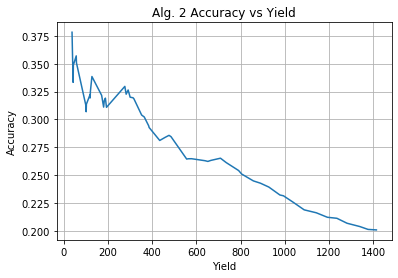

In [264]:
plt.title("Alg. 2 Accuracy vs Yield")
plt.xlabel("Yield")
plt.ylabel("Accuracy")
plt.plot(accs, yields)
plt.grid()
plt.savefig("plots/alg2AccYield.png", dpi = 200)
plt.show()

In [159]:
movieRanks = dfTest.groupby("MovieID").count()["CustomerID"]
movieRanks = movieRanks.reset_index()
movieRanks["CustomerID"] = movieRanks["CustomerID"].to_numpy().argsort().argsort()
movieRanks = dict(movieRanks.to_numpy())

In [168]:
allSolns = []

lastUser = None
for user, day in tqdm(userPairs):
    fullAux = set(dfTrain[dfTrain["CustomerID"] == user]["MovieID"])
    soln = set(dfTest[(dfTest["CustomerID"] == user) & (dfTest["Day"] == day)]["MovieID"])
    soln = soln - fullAux
    if len(soln) > 0:
        allSolns.append((user, day, soln))

In [179]:
correctInfDict = defaultdict(set)
for movieID, user, day in [(x[2], x[0], x[1]) for x in filteredInf if x[5]]:
    correctInfDict[movieID].add((user, day))

In [183]:
correct = defaultdict(int)
total = defaultdict(int)

for user, day, solns in allSolns:
    for movieID in solns:
        if (user, day) in correctInfDict[movieID]:
            correct[movieID] += 1
        total[movieID] += 1

In [192]:
probs = []

for movieID in total.keys():
    probs.append((movieRanks[movieID], correct[movieID] / total[movieID]))
    
probs = sorted(probs, key = lambda x: x[0])

In [253]:
xs = []
ys = []
counter = 0
sampleRate = 80

currRanks = []
currProbs = []
for rank, prob in probs:
    currRanks.append(rank)
    currProbs.append(prob)
    counter += 1
    if counter == sampleRate:
        counter = 0
        xs.append(np.mean(currRanks))
        ys.append(np.mean(currProbs))
        currRanks = []
        currProbs = []

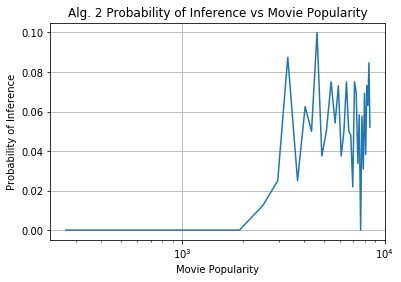

In [263]:
plt.title("Alg. 2 Probability of Inference vs Movie Popularity")
plt.xlabel("Movie Popularity")
plt.ylabel("Probability of Inference")
plt.xscale('log')
plt.plot(xs, ys)
plt.grid()
plt.savefig("plots/alg2Pop.png", dpi = 200)
plt.show()

In [244]:
[x for x in probs if x[1] > 0]

[(2756, 1.0),
 (2840, 1.0),
 (2916, 1.0),
 (3232, 1.0),
 (3233, 1.0),
 (3258, 1.0),
 (3325, 1.0),
 (3399, 1.0),
 (3473, 1.0),
 (3486, 1.0),
 (3669, 1.0),
 (3775, 1.0),
 (3975, 1.0),
 (3980, 1.0),
 (4003, 1.0),
 (4103, 1.0),
 (4153, 1.0),
 (4216, 1.0),
 (4451, 1.0),
 (4453, 1.0),
 (4476, 1.0),
 (4514, 1.0),
 (4551, 1.0),
 (4616, 1.0),
 (4707, 1.0),
 (4712, 1.0),
 (4737, 1.0),
 (4739, 1.0),
 (4742, 1.0),
 (4793, 1.0),
 (4936, 1.0),
 (4950, 1.0),
 (5062, 1.0),
 (5190, 1.0),
 (5233, 1.0),
 (5253, 1.0),
 (5345, 0.5),
 (5369, 1.0),
 (5404, 0.5),
 (5441, 1.0),
 (5471, 1.0),
 (5488, 1.0),
 (5506, 0.5),
 (5545, 0.5),
 (5595, 1.0),
 (5671, 1.0),
 (5679, 1.0),
 (5795, 0.3333333333333333),
 (5797, 1.0),
 (5831, 1.0),
 (5857, 0.3333333333333333),
 (5873, 1.0),
 (5956, 1.0),
 (5983, 1.0),
 (5986, 1.0),
 (5991, 0.5),
 (5994, 1.0),
 (6157, 1.0),
 (6176, 1.0),
 (6207, 1.0),
 (6225, 1.0),
 (6278, 1.0),
 (6354, 1.0),
 (6397, 1.0),
 (6420, 1.0),
 (6438, 1.0),
 (6471, 1.0),
 (6475, 0.5),
 (6519, 1.0),
 (65